## Read .ghg metadata

In [1]:
import preProcessing
import importlib
import time
importlib.reload(preProcessing)
T1 = time.time()

# Need one or more metadata templates if working with .dat files
# template = ['Y:/BBS/TOA5_BBS.FLUX_2023_06_14_1500.metadata']


# pr = preProcessing.read_ALL('BBS',2023,6,reset=1,processes=8,file_type='dat',metadata_template=template)

# for m in range(7,13):
#     pr = preProcessing.read_ALL('BBS',2023,m,processes=8,file_type='dat')

# for m in range(1,4):
#     pr = preProcessing.read_ALL('BBS',2024,m,processes=8,file_type='dat')

# If updates/corrections must be made to metadata (e.g., undocumented orientation changes) a .csv files of updates can be provided
updates = 'C:/highfreq/BB/Metadata_Updates.csv'
y = 2023
m = 6
pr = preProcessing.read_ALL('BB',y,m,processes=4,file_type='ghg',metadata_updates=updates)

T2 = time.time()

print('\n')
print('Runtime: ',(T2-T1)/60,' minutes')



Runtime:  0.02709861993789673  minutes


In [2]:
# https://www.licor.com/env/support/EddyPro/topics/low-pass-filtering.html

hf_corrections = {
    'Moncrieff et al. (1997)':1,
    'Horst (1997)':2,
    'brom et al. (2007)':3,
    'Fratini et al. (2012)':4, # Recommended , when sufficient data (>1 month) are available
    'Massman (2000, 2001)':5
}
bin_sp_avail=[0,1]
full_sp_avail=[0,1]
sa_bin_spectra='Path'
sa_full_spectra = 'Path'


In [3]:
import setupEP as eP
import importlib
import time
importlib.reload(eP)

########## Note - incomplete ghg or biomet files can crash program (preprocessing procedures should help prevent that by re-naming incomplete files)

T1 = time.time()
# mR = eP.makeRun('ep_Templates/DefaultSettings.eddypro','BBS',Processes=6,priority = 'high priority')
# mR.runDates(['2023-01-01 00:00','2024-03-31 23:59'])

# mR = eP.makeRun('ep_Templates/DefaultSettings.eddypro','BB',Processes=6,priority = 'high priority')
mR = eP.makeRun('ep_Templates/DefaultSettings.eddypro','BB',Processes=5,priority = 'high priority')
mR.runDates(['2023-06-01 00:00','2023-06-30 23:59'])

T2 = time.time()
print('\n')
print('Runtime: ',(T2-T1)/60)

Splitting into 2 batches due to update metadata
Running EddyPro[████████████████████████████████████████████████████████████] 6/6

Runtime:  92.2520372112592


## Full Runtime

### Reading & Writing all to Y: drive:

1 Month of BB data (20 hz)

**Preprocessing**: 3.91 minutes (8 cores)
**Processing**: 56.92 minutes (6 cores)

Total: **60.83** minutes

### Reading & Preprocessing on Y: drive then writing EddyPro results locally:

1 Month of BB data (20 hz)

**Preprocessing**: 3.91 minutes (8 cores)
**Processing**: 55.74 minutes (6 cores)

Total: **59.65** minutes

### Copying data to C then writing EddyPro results locally:

1 Month of BB data (20 hz)

**Preprocessing**: 6.30 minutes (1 core copy > 8 core preprocessing)

**Processing**: 54.33 minutes (6 cores)

Total: **60.3** minutes

* Paralellizing data copy could shave enought time to get marginal benfit, but doesn't look to matter much

,wind_speed,u*,wind_dir,Ta_1_1_1,H
TIMESTAMP,,,,,


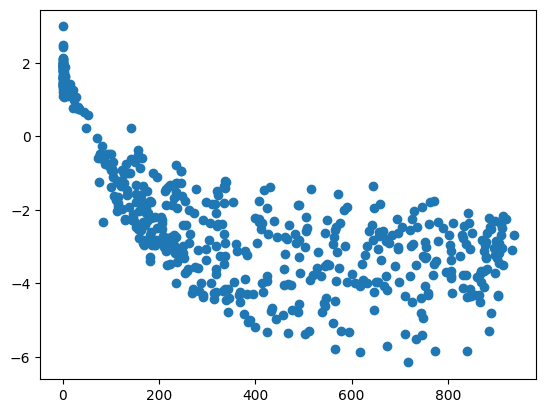

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(mR.all_outputs['fulloutput'],skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')
bm = pd.read_csv(mR.all_outputs['biomet'],skiprows=[1],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')

df = pd.concat([df,bm[['RH_1_1_1','Ta_1_1_1','Rg_1_1_1','LWIN_1_1_1']]],axis=1)
df.loc[df['qc_co2_flux']>0,'co2_flux']=np.nan
df.loc[df['u*']<0.15,'co2_flux']=np.nan

plt.scatter(df['Rg_1_1_1'],df['co2_flux'])

df.loc[df['co2_flux']>20,['wind_speed','u*','wind_dir','Ta_1_1_1','H']]


       LE_fratini  LE_moncrieff  co2_flux_fratini  co2_flux_moncrieff  \
count  631.000000    631.000000        632.000000          632.000000   
mean   144.636420     89.989152         -2.951890           -2.787909   
std     97.742998     68.121140          1.781290            1.674116   
min     -3.155810     -1.534000         -6.908220           -6.401300   
25%     54.598200     30.411600         -4.202545           -3.914795   
50%    134.368000     77.578200         -3.247335           -3.003040   
75%    228.864000    142.503500         -1.948213           -2.045008   
max    353.413000    304.631000          2.777310            2.618130   

       ch4_flux_fratini  ch4_flux_moncrieff  
count        429.000000          416.000000  
mean           0.071349            0.065084  
std            0.019590            0.018232  
min           -0.040812           -0.048186  
25%            0.058727            0.052846  
50%            0.070767            0.063425  
75%            0.084

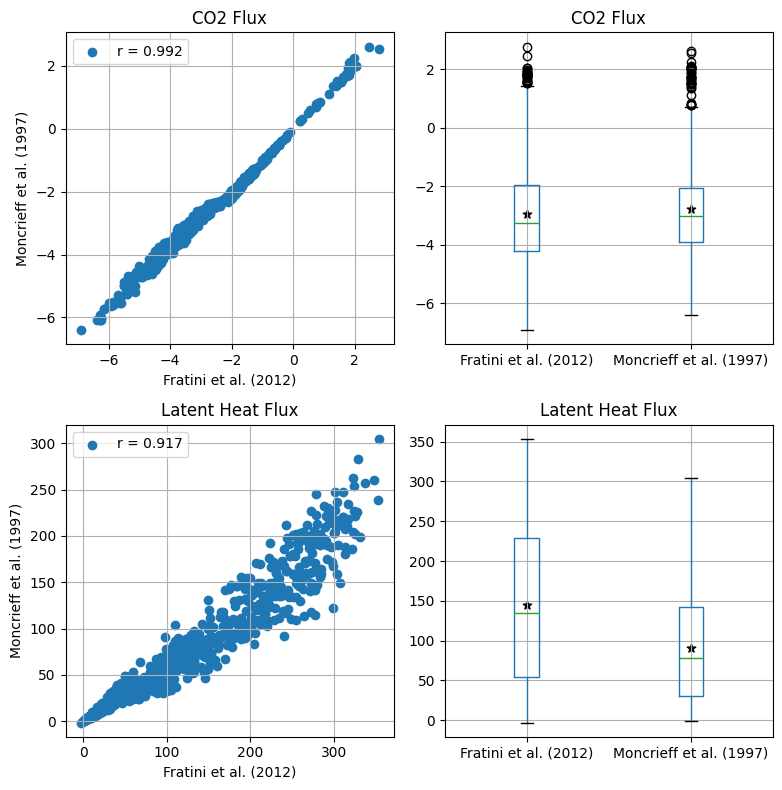

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
monc = 'Y:\\BB\\Spectral_Comp\\Moncrieff/'+'eddypro_BB_20230601_20230630_full_output_2024-03-15T153700_adv.csv'
frat = 'Y:\\BB\\Spectral_Comp\\Fratini/'+'eddypro_Spectral_Correction_fratini_full_output_2024-03-19T000447_adv.csv'
df_fratini = pd.read_csv(frat,skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')
df_moncrieff = pd.read_csv(monc,skiprows=[0,2],na_values=-9999,parse_dates={'TIMESTAMP':['date','time']},index_col='TIMESTAMP')

def Filt(df):
    df['filt'] = 1
    df.loc[df['u*']<.15,'filt']=np.nan
    df.loc[df['qc_co2_flux']>0,'filt']=np.nan
    df.loc[df['qc_LE']>0,'filt']=np.nan
    return(df)

df_fratini = Filt(df_fratini)
df_moncrieff = Filt(df_moncrieff)


# df_fratini=df_fratini.loc[df_fratini.index.month==6].copy()

cols = ['filt','u*','co2_flux','qc_co2_flux','LE','qc_LE','H','qc_H','ch4_flux','qc_ch4_flux']
frat_cols = {key: key+'_fratini' for key in cols}
monc_cols = {key: key+'_moncrieff' for key in cols}

df_fratini = df_fratini[cols].rename(columns=frat_cols)
df_moncrieff = df_moncrieff[cols].rename(columns=monc_cols)

df = df_fratini.join(df_moncrieff)

df['filt']=df['filt_fratini']*df['filt_moncrieff']

for col in df.columns:
    if col !='filt':
        df[col]=df[col]*df['filt']


fig,ax=plt.subplots(2,2,figsize=(8,8))


ax[0,0].scatter(df['co2_flux_fratini'],df['co2_flux_moncrieff'],label=f"r2 = {(df[['co2_flux_fratini','co2_flux_moncrieff']].corr()**2)['co2_flux_moncrieff'].round(3).values[0]}")
ax[0,0].set_xlabel('Fratini et al. (2012)')
ax[0,0].set_ylabel('Moncrieff et al. (1997)')
ax[0,0].set_title('CO2 Flux')
ax[0,0].legend()
ax[0,0].grid()

df[['co2_flux_fratini','co2_flux_moncrieff']].boxplot(ax=ax[0,1])
ax[0,1].scatter([1,2],df[['co2_flux_fratini','co2_flux_moncrieff']].mean().values,marker='*',s=40,color='k')
ax[0,1].set_xticklabels(['Fratini et al. (2012)','Moncrieff et al. (1997)'])
ax[0,1].set_title('CO2 Flux')


ax[1,0].scatter(df['LE_fratini'],df['LE_moncrieff'],label=f"r2 = {(df[['LE_fratini','LE_moncrieff']].corr()**2)['LE_moncrieff'].round(3).values[0]}")
ax[1,0].set_xlabel('Fratini et al. (2012)')
ax[1,0].set_ylabel('Moncrieff et al. (1997)')
ax[1,0].set_title('Latent Heat Flux')
ax[1,0].legend()
ax[1,0].grid()

df[['LE_fratini','LE_moncrieff']].boxplot(ax=ax[1,1])
ax[1,1].scatter([1,2],df[['LE_fratini','LE_moncrieff']].mean().values,marker='*',s=40,color='k')
ax[1,1].set_xticklabels(['Fratini et al. (2012)','Moncrieff et al. (1997)'])
ax[1,1].set_title('Latent Heat Flux')

plt.tight_layout()


print(df[['LE_fratini','LE_moncrieff','co2_flux_fratini','co2_flux_moncrieff','ch4_flux_fratini','ch4_flux_moncrieff',]].describe())

# Speedtests

All times in minutes

### 4 threads (8 timesteps each)

Normal priority: 2.05
High priority: 1.91

### 4 threads (48 timesteps each x 12 days)

High priority: 29

### Eddypro GUI (1 run [12 days, 576 timesteps])

High priority: 90